In [ ]:
!nvidia-smi

Sat Sep 12 12:04:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets

#import spacy
import numpy as np
from sklearn.model_selection import KFold 

import time
import random

import nltk
from nltk import word_tokenize
from nltk.corpus import brown 
import random
import matplotlib.pyplot as plt
nltk.download('brown')
nltk.download('universal_tagset')

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

tagged_sent=nltk.corpus.brown.tagged_sents(tagset='universal')
print("Number of Tagged Sentences ",len(tagged_sent))

c1=int(0.8*len(tagged_sent))
#c2=int(0.8*len(tagged_sent))

trainset=tagged_sent[:c1]
#print(trainset)
#valset=tagged_sent[c1:c2]
testset=tagged_sent[c1:]

word_to_idx={}
tag_to_idx={}

def seq_to_idx(seq, idx):
    return torch.tensor([idx[s] for s in seq], dtype=torch.long)

for sent in tagged_sent:
    for word, pos_tag in sent:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)

class BiLSTMPOSTagger(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):#,pad_idx):
        super().__init__()

        self.embedding=nn.Embedding(input_dim,embedding_dim)#,padding_idx=pad_idx)

        self.lstm=nn.LSTM(embedding_dim, hidden_dim,num_layers=n_layers,bidirectional=bidirectional,dropout=dropout if n_layers>1 else 0)

        self.fc=nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)

        #self.dropout=nn.Dropout(dropout)

    def forward(self,text):
        embed=self.embedding(text)
        outputs, (hidden,cell)= self.lstm(embed.view(len(text),1,-1))
        prediction=self.fc(outputs.view(len(text),-1))
        tag_scores = F.log_softmax(prediction, dim=1)

        return tag_scores

INPUT_DIM = len(word_to_idx)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(tag_to_idx)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
print(INPUT_DIM)
print(OUTPUT_DIM)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
Number of Tagged Sentences  57340
56057
12


'\nmodel=BiLSTMPOSTagger(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)#,PAD_IDX)\n\nuse_cuda = torch.cuda.is_available()\ndevice = torch.device("cuda:0" if use_cuda else "cpu")\n\nif use_cuda:\n    model.cuda()\n\nloss_function = nn.NLLLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.01)\n\n# Training start\nprint("Training Started")\naccuracy_list = []\nloss_list = []\ninterval = round(len(trainset) / 100.)\nepochs = 10\ne_interval = round(epochs / 10.)\nfor epoch in range(epochs):\n    acc = 0 #to keep track of accuracy\n    loss = 0 # To keep track of the loss value\n    i = 0\n    for sent_tag in trainset:\n        i += 1\n        sent = [s[0] for s in sent_tag]\n        sent = torch.tensor(seq_to_idx(sent, word_to_idx), dtype=torch.long).to(device)\n        tags = [s[1] for s in sent_tag]\n        tags = torch.tensor(seq_to_idx(tags, tag_to_idx), dtype=torch.long).to(device)\n        \n        model.zero_grad()\n        \n        tag_scores =

In [ ]:
#k-fold cross validation
kf=KFold(n_splits=5)
epochs = 5
#numSent=len(tagged_sent)
finalAcc=0
fold=0
l1 = list([])
l = [l1.extend(list(zip(*i))[1]) for i in tagged_sent]
tag = list(set(l1))
#print(tags)
tagged_sent=np.array(tagged_sent)
#alpha=0
confusionMatrix = dict(zip(tag,[dict(zip(tag,[0]*len(tag))) for i in range(len(tag))]))

def get_key(val): 
    for key, value in tag_to_idx.items(): 
         if val == value: 
             return key 

for trainidx, testidx in kf.split(tagged_sent):
  trainSent=tagged_sent[trainidx]
  testSent=tagged_sent[testidx]
  print("Training for {} fold".format(fold))

  model1=BiLSTMPOSTagger(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)#,PAD_IDX)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  if use_cuda:
      model1.cuda()

  loss_function = nn.NLLLoss()
  optimizer = optim.Adam(model1.parameters(), lr=0.01)

  model1.train()
  accuracy_list = []
  loss_list = []
  interval = round(len(trainSent) / 100.)
  epochs = 5
  e_interval = 1

  for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sent_tag in trainSent:
        i += 1
        sent = [s[0] for s in sent_tag]
        sent = torch.tensor(seq_to_idx(sent, word_to_idx), dtype=torch.long).to(device)
        tags = [s[1] for s in sent_tag]
        tags = torch.tensor(seq_to_idx(tags, tag_to_idx), dtype=torch.long).to(device)
        
        model1.zero_grad()
        
        tag_scores = model1(sent)
        
        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
        acc += torch.mean(torch.tensor(tags == indices, dtype=torch.float))

    loss = loss / len(trainSent)
    acc = acc / len(trainSent)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))

  
  model1.eval()
  test_loss=0
  correct=0
  #print(tag_to_idx)
  j=0
  countWords = 0
  for sent_tag in testSent:
      countWords += len(sent_tag)
      sent = [s[0] for s in sent_tag]
      sent = torch.tensor(seq_to_idx(sent, word_to_idx), dtype=torch.long).to(device)
      tags = [s[1] for s in sent_tag]
      real_tags=tags
      real_tags=np.asarray(real_tags)
      real_tags=real_tags.astype('str')
      tags = torch.tensor(seq_to_idx(tags, tag_to_idx), dtype=torch.long).to(device)

      output=model1(sent)
      test_loss+=loss_function(output,tags).item()
      pred=output.argmax(dim=1,keepdim=True)
      truth=pred.cpu().detach().numpy()
      truth=truth.astype(int)
      correct+=pred.eq(tags.view_as(pred)).sum().item()
      for predictedTag,tag in zip(truth,real_tags):
        alpha=get_key(predictedTag[0])
        confusionMatrix[tag][alpha]+=1

  finalAcc += correct/countWords
  print("Accuracy on the test set for fold {} is {}".format(fold,correct/countWords))
  fold+=1
print("Average Accuracy on the 5 folds is {}".format(finalAcc/5))


Training for 0 fold


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 Completed,	Loss 2.252886952192057e-05	Accuracy: 0.8848376870155334
Epoch 2 Completed,	Loss 1.1476660802145489e-05	Accuracy: 0.9086595773696899
Epoch 3 Completed,	Loss 1.314533619733993e-05	Accuracy: 0.9151076078414917
Epoch 4 Completed,	Loss 1.3178057997720316e-05	Accuracy: 0.9183508157730103
Epoch 5 Completed,	Loss 1.1640401680779178e-05	Accuracy: 0.9203011393547058


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy on the test set for fold 0 is 0.9132129733184214
Training for 1 fold
Epoch 1 Completed,	Loss 1.691475699772127e-05	Accuracy: 0.8928335309028625
Epoch 2 Completed,	Loss 2.4491015210514888e-05	Accuracy: 0.9154862761497498
Epoch 3 Completed,	Loss 1.868530125648249e-05	Accuracy: 0.9209190607070923
Epoch 4 Completed,	Loss 2.6317407900933176e-05	Accuracy: 0.9229763746261597
Epoch 5 Completed,	Loss 2.5881210603984073e-05	Accuracy: 0.923398494720459
Accuracy on the test set for fold 1 is 0.917264858441329
Training for 2 fold
Epoch 1 Completed,	Loss 2.835501254594419e-05	Accuracy: 0.8842433094978333
Epoch 2 Completed,	Loss 1.9022545529878698e-05	Accuracy: 0.9098756909370422
Epoch 3 Completed,	Loss 1.2774509741575457e-05	Accuracy: 0.9161379933357239
Epoch 4 Completed,	Loss 1.5120876014407258e-05	Accuracy: 0.9196614027023315
Epoch 5 Completed,	Loss 1.1919601092813537e-05	Accuracy: 0.922163188457489
Accuracy on the test set for fold 2 is 0.9204567489746563
Training for 3 fold
Epoch 1 Comp

In [ ]:
# Code for beautifying confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.savefig('confM')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


24


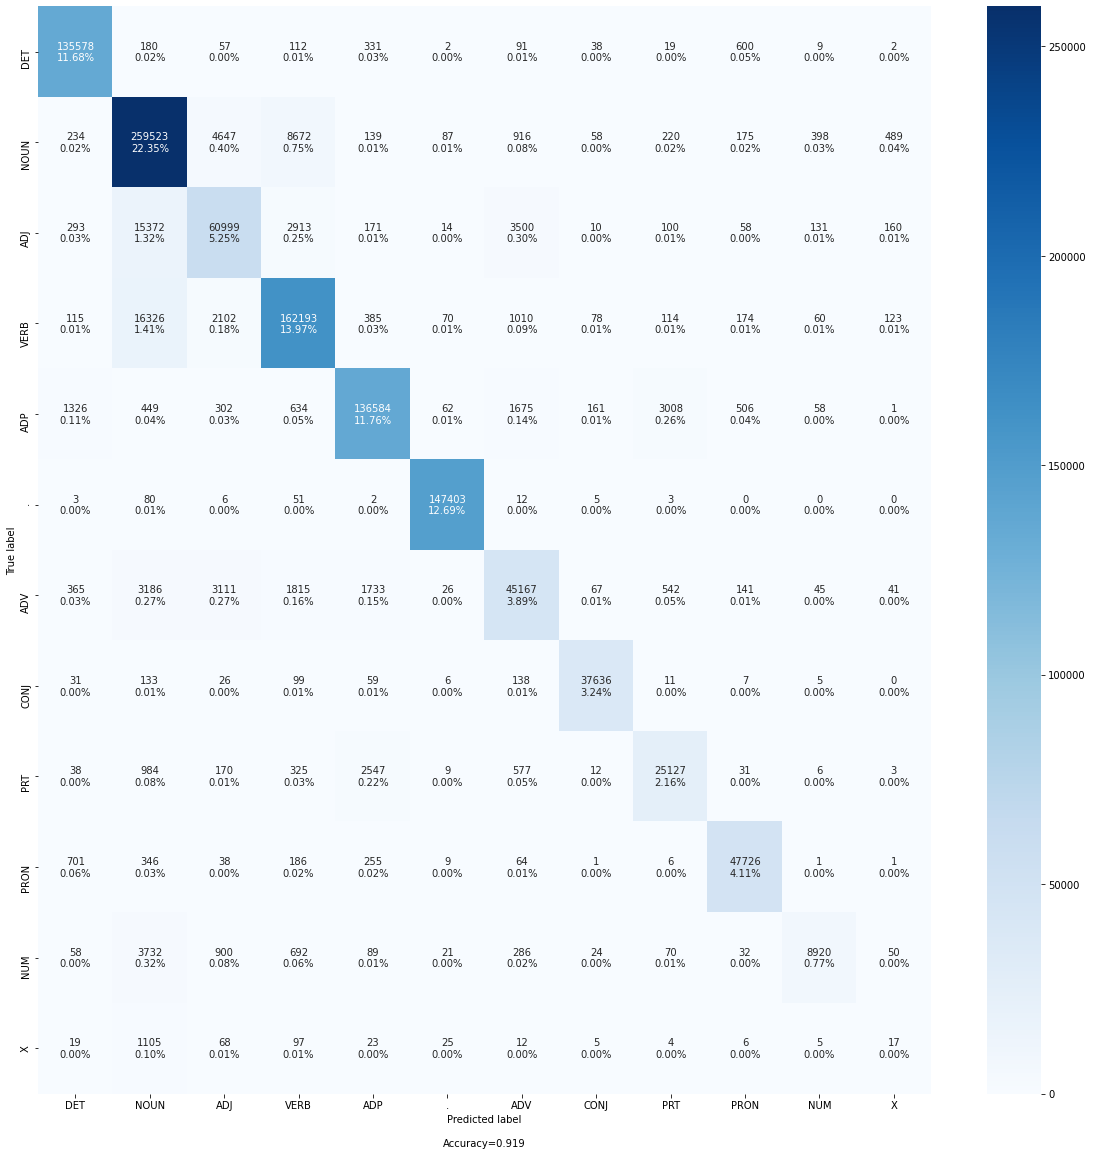

In [ ]:
# Prints the confusion matrix
import seaborn as sns
t=[]
for key,val in tag_to_idx.items():
  t.append(key)
print(len(tags))
sot = len(t)
cm = [[0]*sot for i in range(sot)]
for i in range(sot):
  for j in range(sot):
    cm[i][j] = confusionMatrix[t[i]][t[j]]

cm = np.array(cm)
categories = t
make_confusion_matrix(cm,figsize=(20,20),categories=categories)

In [ ]:
cm.diagonal()/cm.sum(axis=1)

array([0.98948321, 0.94180898, 0.72859856, 0.887513  , 0.9434812 ,
       0.99890218, 0.80312594, 0.98650101, 0.84236817, 0.96740585,
       0.59970418, 0.01226551])